In [15]:
import pandas
import scipy.io
import numpy
import matplotlib.pylab as plt

In [16]:

raw_spectra = scipy.io.loadmat('/Users/Alex/Documents/NMR RSPA/October_Data/october_data_raw_TSPN_data.mat') #loading in tsp adjusted and normalized data
processed_spectra = scipy.io.loadmat('/Users/Alex/Documents/NMR RSPA/October_Data/uiAlignmentData.mat')

processed_ppm = scipy.io.loadmat('/Users/Alex/Documents/NMR RSPA/October_Data/uiAlignmentData.mat')
processed_ppm = processed_ppm['uiAlignmentData']['ppm'][0][0]

#print(raw_spectra['X'])
#print(max(processed_ppm), min(processed_ppm))

In [17]:
# Extract the ppm and 1-D spectra from the matlab data object.
ppm = raw_spectra['uiAlignmentData']['ppm'][0][0] #raw_spectra['ppm'] 
X = raw_spectra['uiAlignmentData']['SpAL'][0][0]#raw_spectra['X']
print(X)
print(ppm.shape,X.shape)

# get the processed spectra from the matlab objects
processed_X = processed_spectra['uiAlignmentData']['SpAL'][0][0]
print(processed_ppm.shape,processed_X.shape)

[[-5.63403776e-01 -5.10151087e-01 -4.56898399e-01 ...  8.17404080e-01
   8.74423997e-01  8.74423997e-01]
 [ 8.73932008e-02 -4.95589044e-02 -1.86799679e-01 ...  6.45292642e-01
   8.40482757e-01  1.45345436e-01]
 [-1.60463733e-01 -4.00041280e-01 -2.60246427e-01 ...  1.05541544e-01
   1.05541544e-01  1.05541544e-01]
 ...
 [-4.15837922e-01 -8.42811734e-01 -4.41696663e-01 ...  9.31459998e-01
   8.77021128e-01  1.32508695e-01]
 [ 2.79115416e-04 -1.11646052e-03 -4.41559374e-01 ... -4.00251285e-01
  -2.98932598e-01 -1.97613911e-01]
 [-5.63403776e-01 -5.10151087e-01 -4.56898399e-01 ...  8.17404080e-01
   8.74423997e-01  8.74423997e-01]]
(1, 51491) (181, 51491)
(1, 51491) (181, 51491)


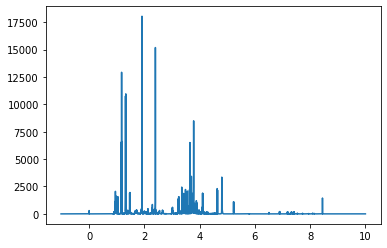

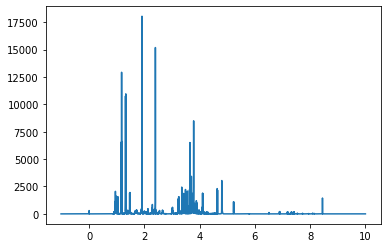

In [18]:
# plot the processed data
fig, ax = plt.subplots()
ax.plot(processed_ppm[0,:],processed_X[0,:])
plt.show()

# plot the raw data for comparison
fig, ax = plt.subplots()
ax.plot(ppm[0,:],X[0,:])
plt.show()

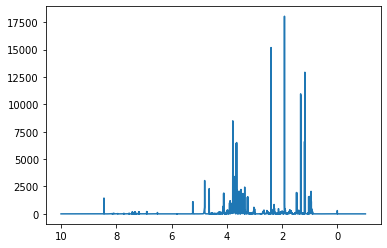

51488


'X_flips = []\nfor i in X_flip:\n    X_flips.append(i[0:-1])\nX_flips = numpy.array(X_flips)\nprint(X_flips.shape)\nX_flip = X_flips'

In [19]:
## Repeat some of the basic sample filtering we performed prior to alignment in our previous study
# These steps will remove the TSP signal (used for signal intensity normalization
# and as a chemical shift reference at 0ppm), water (strong signal at 4.55ppm), and
# the long lower tail of the spectra which doesn't contain anything.

# flip the spectra and ppm to the typical orientation
ppm_flip = numpy.flip(ppm,1)
X_flip = numpy.flip(X,1)

#flipping processed data to typical orientation
processed_ppm_flip = numpy.flip(processed_ppm,1)
processed_X_flip = numpy.flip(processed_X,1)

fig, ax = plt.subplots()
ax.plot(ppm_flip[0,:],X_flip[0,:])
ax.invert_xaxis()
plt.show()

# remove TSP, which was used for normalization (normalized the entire spectra by 
# forcing an area of 1 under the TSP peak at 0 ppm).
water_start =  4.55 # start of water signal, in ppm
water_end = 5.05 # end of water signal, in ppm
tsp_start = -0.2
tsp_end = 0.2
low_tail_start = -1.0
low_tail_end = 0.5

# Let's write a convenient function for deleting regions of a spectrum and ppm data
def delete_spectra_portion(in_spectra,in_ppm,lower_bound,upper_bound):
    """
    Delete the region of a spectrum and the ppm vector between lower_bound
    and upper_bound. Returns new spectra and ppm in a tuple as (spectra, ppm).
    +1 in upper bound of arange matches the MATLAB behavior during indexing.
    """
    return (numpy.delete(in_spectra,
                numpy.arange(
                    numpy.argmax(in_ppm>=lower_bound),
                    numpy.argmax(in_ppm>=upper_bound)+1),
                axis=1),
           numpy.delete(in_ppm,
                numpy.arange(
                    numpy.argmax(in_ppm>=lower_bound),
                    numpy.argmax(in_ppm>=upper_bound)+1),
                axis=1))

# Now modify the raw spectra with the deletion function.
# After these modifications, the "raw" data is directly comparable to the processed,
# aligned data, AND has the same dimensions.
X_flip,ppm_flip = delete_spectra_portion(X_flip,ppm_flip,water_start,water_end)
X_flip,ppm_flip = delete_spectra_portion(X_flip,ppm_flip,tsp_start,tsp_end)
X_flip,ppm_flip = delete_spectra_portion(X_flip,ppm_flip,low_tail_start,low_tail_end)

#remove water from clean spectra
processed_X_flip,processed_ppm_flip = delete_spectra_portion(processed_X_flip,processed_ppm_flip,water_start,water_end)
processed_X_flip,processed_ppm_flip = delete_spectra_portion(processed_X_flip,processed_ppm_flip,tsp_start,tsp_end)
processed_X_flip,processed_ppm_flip = delete_spectra_portion(processed_X_flip,processed_ppm_flip,low_tail_start,low_tail_end)

print(len(processed_X_flip[0]))

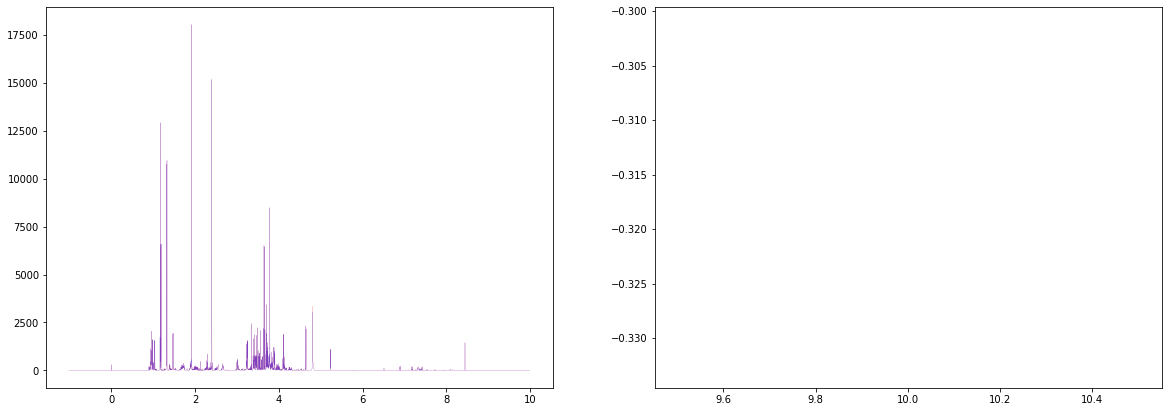

In [20]:
# We can plot the spectra from a single sample in the pre- vs. post-processed data to
# see differences. When visualizing the entire spectra, it's hard to see differences;
# we'll use the right panel to visualize the region of a single sample where there is the
# largest difference between pre- and post-processed spectra.
fig, axes = plt.subplots(1,2)
axes[0].plot(processed_ppm[0,:],processed_X[0,:],c='red',alpha=0.5,linewidth=0.2)
axes[0].plot(ppm_flip[0,:],X_flip[0,:],c='blue',alpha=0.5,linewidth=0.2)

# For a specific sample/row, lets find the region of the spectra that has the largest difference
# between pre- and post-processing, then visualize the difference in that region.
sample = 6
max_index = numpy.argmax((processed_X_flip[sample,:]-X_flip[sample,:]) >= numpy.max(processed_X_flip[sample,:]-X_flip[sample,:]))
target_ppm = processed_ppm[0,max_index]
lower_ppm = numpy.argmax(processed_ppm_flip>=target_ppm-0.03)
upper_ppm =  numpy.argmax(processed_ppm_flip>=target_ppm+0.03)+1
axes[1].plot(processed_ppm_flip[0,lower_ppm:upper_ppm],processed_X_flip[sample,lower_ppm:upper_ppm],c='red',alpha=0.8,linewidth=0.4)
axes[1].plot(ppm_flip[0,lower_ppm:upper_ppm],X_flip[sample,lower_ppm:upper_ppm],c='blue',alpha=0.8,linewidth=0.4)

fig.set_size_inches(20,7)
plt.show()

In [21]:
# Let's save the numpy arrays for pre- and post-processing
with open("/Users/Alex/Documents/NMR RSPA/NUMPY Files/october_data_processed_x_realignment1.npy", "wb") as file:
    numpy.save(file,processed_X_flip)
with open("/Users/Alex/Documents/NMR RSPA/NUMPY Files/october_data_processed_ppm.npy", "wb") as file:
    numpy.save(file,processed_ppm_flip)
with open("/Users/Alex/Documents/NMR RSPA/NUMPY Files/october_data_raw_TSPN_X.npy", "wb") as file:
    numpy.save(file,X_flip) #change for raw or tsp adjusted
with open("/Users/Alex/Documents/NMR RSPA/NUMPY Files/ocotber_data_raw_ppm.npy", "wb") as file:
    numpy.save(file,ppm_flip)

(181, 51488) (181, 51488)


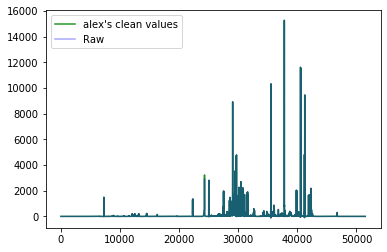

In [15]:
#Plotting for comparison
print(processed_X_flip.shape, X_flip.shape)
plt.plot(range(len(X_flip[0])),processed_X_flip[41], color = 'green', alpha = 0.85, label = "clean values")
plt.plot(range(len(X_flip[0])),X_flip[41], color = 'blue', alpha = 0.35, label = "Raw" )
#plt.axis([30000,35000,0, 1.2*10**7])
plt.legend()
plt.show()